# My year of plastic in 10 charts

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from scipy import stats #for streamgraph
import seaborn as sns
import matplotlib.patches as patches
import pickle
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from datetime import date, datetime

%matplotlib inline

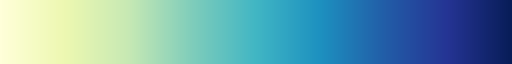

In [2]:
from palettable.cartocolors.sequential import Magenta_7, PurpOr_7, BluYl_7, DarkMint_7
from palettable.colorbrewer.sequential import YlGnBu_9, Blues_9
YlGnBu_9.mpl_colormap

In [3]:
# set root folder
root = os.path.abspath(os.path.join(os.getcwd(), ".."))

#get data - open pickled file
file = open(os.path.join(root, "data\\lisa_plastic_records_history_clean"),'rb')
df = pickle.load(file)
file.close()

In [4]:
#font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
#set fonts for plots
font_r = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Ubuntu-R.ttf')
font_m = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-M.ttf')
font_b = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Ubuntu-B.ttf')

# Preparation

## aggregated data per day

In [5]:
#aggregate data by day + category
data_daily = df.groupby(["date", "category_name", "sub_category_name"]).agg({"plastic_weight":"sum",
                                                                            "score":"sum", 
                                                                            "quantity": "sum",
                                                                            "DV_plastic_weight":"sum"})
data_daily = data_daily.reset_index()

#get all days for 2021 and join with data
all_days = pd.DataFrame(pd.date_range('1/1/2021', periods=365, freq='D')).rename(columns={0:"date"})
df_daily = pd.merge(all_days, data_daily, left_on="date", right_on = "date", how='outer')

In [6]:
#get calendarweeks and month

df["ISOyear"] = df["date"].dt.isocalendar()["year"]
df["ISOweek"] = df["date"].dt.isocalendar()["week"]

#get weeks commencing
weeks = df[["ISOyear", "ISOweek"]].drop_duplicates().reset_index(drop=True)

week_commencing = []

for i in range(len(weeks)):
    x = pd.to_datetime(date.fromisocalendar(weeks["ISOyear"][i],weeks["ISOweek"][i],1))
    week_commencing.append(x)
    
weeks["week_commencing"] = week_commencing

#merge back to dataframe
df = pd.merge(df, weeks, left_on=["ISOyear", "ISOweek"], right_on=["ISOyear", "ISOweek"], how='left')

#get month based on weeks commencing
df["month"] = df["week_commencing"].dt.month
df.loc[df["week_commencing"] =="2020-12-28", "month"] = 1

# 0. Overview poster

## Total weight

In [59]:
df["DV_plastic_weight"].sum()/2

15967.0

## Total weight per category

In [41]:
pivot = df.groupby("category_name")["DV_plastic_weight"].sum().to_frame()
pivot = pivot.sort_values(by="DV_plastic_weight", ascending=False)
pivot["Percent"] = pivot["DV_plastic_weight"]/ (pivot["DV_plastic_weight"].sum()) *100
pivot

,DV_plastic_weight,Percent
category_name,,
"Pots, tubs, trays",10821,33.885514
Bottles,10707,33.528528
Bags and film,6096,19.089372
Cupboard and Hygiene,3280,10.271184
Other,968,3.031252
Drinks,62,0.19415


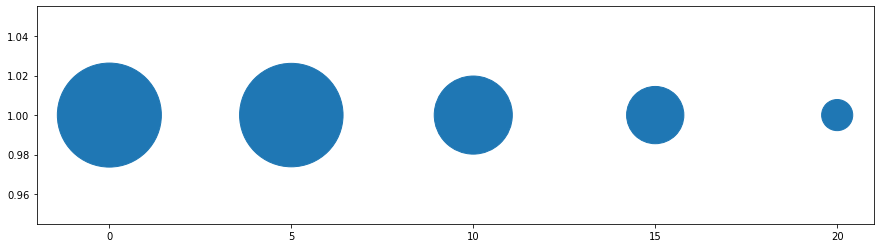

In [35]:
data = pivot.iloc[:5]["DV_plastic_weight"].to_list()

fig, ax = plt.subplots(figsize=(15, 4))
plt.scatter([0,5,10,15,20], [1,1,1,1,1], s=data)
plt.gca().set_xlim(xmin=-2)

#export to svg
plt.savefig(os.path.join(root, "outputs//bubbles.svg"))

plt.show()

## Largest category per month

In [57]:
pivot = df.groupby(["month","category_name"])["DV_plastic_weight"].sum().to_frame()
pivot.unstack()
#max = pivot.groupby("month")["DV_plastic_weight"].max().to_frame().reset_index()
#max = pd.merge(max, pivot, left_on=["month","DV_plastic_weight"], right_on=["month","DV_plastic_weight"], how='left')
#max
#pivot.unstack()



DV_plastic_weight                                            \
category_name     Bags and film Bottles Cupboard and Hygiene Drinks Other   
month                                                                       
1                           769    1006                  273      2   118   
2                           541     796                  212     10   349   
3                           640     943                  380     12    53   
4                           565     658                  439      4    61   
5                           510     995                  245      5    30   
6                           394    1036                  358      1    59   
7                           466    1155                  199      8   130   
8                           626    1205                  435     10    33   
9                           402     696                  272      4    84   
10                          315     706                   29    NaN     7   
11                          511     801                   70      2    11   
12                          357     710                  368      4    33   

                                 
category_name Pots, tubs, trays  
month                            
1                          1133  
2                          1152  
3                          1162  
4                          1010  
5                          1036  
6                           879  
7                           865  
8                          1066  
9                           763  
10                          533  
11                          565  
12                          657

## Radar plot

In [27]:
# get bin number by day for heatmap calendar view 
pivot = df.groupby("date")["DV_plastic_weight"].sum()
counts, bin_edges = np.histogram(pivot, bins=5)
print(bin_edges)

pivot = df.groupby("date")["DV_plastic_weight"].sum()
pivot = pivot.to_frame()
day_bins = []

for weight in pivot["DV_plastic_weight"]:
    if weight <=81.8:
        day_bins.append(1)
    elif (weight > 81.8) & (weight <= 154.6):
        day_bins.append(2)   
    elif (weight > 154.6) & (weight <= 227.4):
        day_bins.append(3)  
    elif (weight > 227.3) & (weight <= 300.2):
        day_bins.append(4)      
    elif weight > 300.2:
        day_bins.append(5)  
        
pivot["day_bins"] = day_bins

pivot.to_csv("day_bins.csv")

array([9.0, 81.8, 154.6, 227.39999999999998, 300.2, 373.0], dtype=object)

In [40]:
pivot = df.groupby(["date", 
                    "week_commencing"])["DV_plastic_weight"].sum().to_frame().reset_index()

#append empty weight for missing week
new_values = [pd.to_datetime("2021-10-04"), pd.to_datetime("2021-10-04"), 0]
length = len(pivot)
pivot.loc[length] = new_values

pivot = pivot.sort_values(by="week_commencing")
pivot.head()

,date,week_commencing,DV_plastic_weight
0,2021-01-01,2020-12-28,91
1,2021-01-02,2020-12-28,135
2,2021-01-03,2020-12-28,55
8,2021-01-09,2021-01-04,156
7,2021-01-08,2021-01-04,54


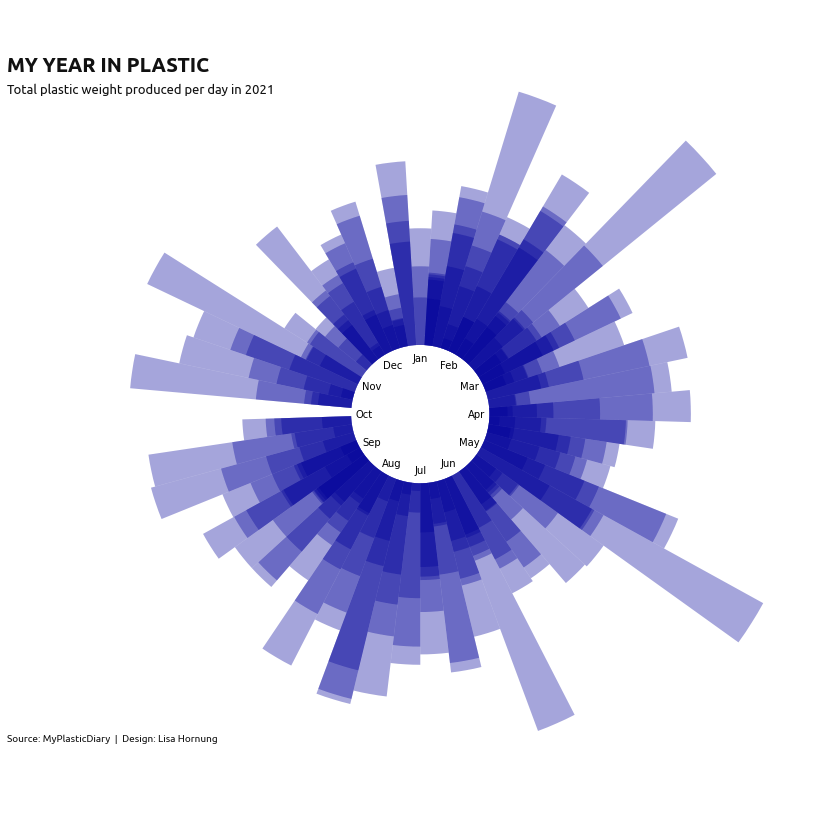

In [43]:
data = pivot

# =========
# Initialise Figure and define layout
plt.figure(figsize=(15, 15))
ax = plt.subplot(111, polar=True)

# ============
#data
n_points = len(data["week_commencing"].unique())
inner_radius = 80
bar1 = data["DV_plastic_weight"]

x_max = 2*np.pi
x_coords = np.linspace(0, x_max, n_points, endpoint=False)
width = x_max / n_points

#map x_coords to week commencing
dictionary = dict(zip(data["week_commencing"].unique(), x_coords))
x_pos = data["week_commencing"].map(dictionary)

#add bars
ax.bar(
    x_pos,
    bar1,
    width=width,
    bottom=inner_radius,
    color="#000099",
    alpha=0.35
)

#============
# labels for months
l_points = 12
label_x_pos = np.linspace(0, x_max, l_points, endpoint=False)
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#add value labels and categories
for i in range(l_points):
    ax.text(label_x_pos[i], 65, 
            labels[i],
            size=10,
            ha="center", va='center')

#add value labels and categories
#for i in range(n_points):
 #   ax.text(x_coords[i], 295, 
    #        (str(pd.to_datetime(data["week_commencing"].unique()[i]).year) + "-" + 
    #        str(pd.to_datetime(data["week_commencing"].unique()[i]).month) + "-" +
    #        str(pd.to_datetime(data["week_commencing"].unique()[i]).day)) ,
    #        ha="left")
    #ax.text(x_coords[i], bar1[i]-10, bar1[i], ha="center", va='center')

#configure theta location and direction
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.axis('off')

# =========
#title and footer
title = "MY YEAR IN PLASTIC"
subtitle = "Total plastic weight produced per day in 2021"
x_title=0.13
plt.figtext(x_title,0.82, title, size=20, ha='left',  fontproperties = font_b, color='#111111')
plt.figtext(x_title,0.8, subtitle, size=13,ha='left',  fontproperties = font_r, color='#111111')

plt.figtext(x_title,0.2, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=10, ha='left', fontproperties = font_r, color='#111111')


#save
plt.savefig(os.path.join(root, "outputs//radar-plot.png"), bbox_inches="tight",pad_inches=0.2, transparent=False)
plt.savefig(os.path.join(root, "outputs//radar-plot.svg"))

plt.show()

# Chart 1 - calendar heatmap

In [15]:
#Fontstyles
def get_text():
    font_r = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Montserrat-Regular.ttf')
    font_b = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Montserrat-Bold.ttf')

    title = ("One year of recording our plastic waste").upper()
    subtitle = "Total plastic weight per day, 2021 (g)"
    
    return(font_r, font_b, title, subtitle)

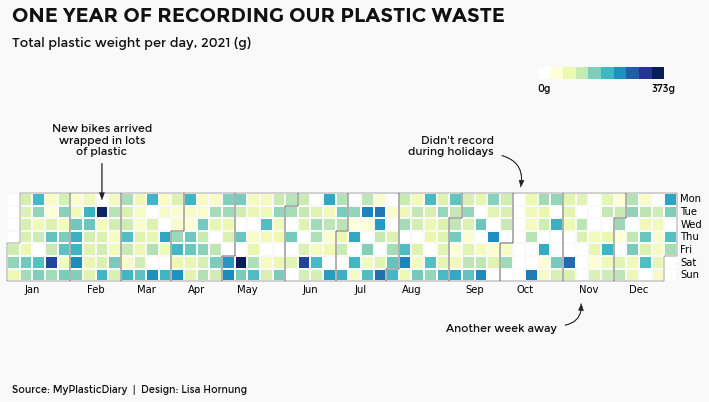

In [20]:
import calplot

#prepare data
all_days = pd.date_range('1/1/2021', periods=365, freq='D')
events = df_daily.groupby("date")["DV_plastic_weight"].sum()
events = pd.Series(events, index=all_days)

#set colour + get text properties
color = YlGnBu_9
b_color = "#f9f9f9"
font_r, font_b, title, subtitle = get_text()

#### plot
fig, ax = plt.subplots(figsize=(12,5))
fig.set_facecolor(b_color)
ax = calplot.yearplot(events, cmap=color.mpl_colormap, linewidth=0.4, linecolor=b_color, fillcolor='white',
                      edgecolor = '#333333',  dropzero=True)

# =========
# Arrows
#define style
style = "Simple, tail_width=0.5, head_width=5, head_length=7"
kw = dict(arrowstyle=style, color="#222222")

#define arrows
a1 = patches.FancyArrowPatch((7.5, 9.5), (7.5, 6.3),linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw, clip_on=False)
a2 = patches.FancyArrowPatch((39, 10), (40.6, 7.3),linewidth=0.5,
                            connectionstyle="arc3,rad=-.5", **kw, clip_on=False)
a3 = patches.FancyArrowPatch((44, -3.5), (45.4, -1.6),linewidth=0.5,
                            connectionstyle="arc3,rad=.5", **kw, clip_on=False)

#add arrows to plot
for a in [a1, a2,a3]:
    ax.add_patch(a)

## =========
#annotations
ax.text(7.5,10, "New bikes arrived\nwrapped in lots\nof plastic", fontsize=11, ha='center', fontproperties = font_r, color='#111111')  
ax.text(38.5, 10, "Didn't record\nduring holidays", fontsize=11, ha='right', fontproperties = font_r, color='#111111')
ax.text(43.5, -4, "Another week away", fontsize=11, ha='right', fontproperties = font_r, color='#111111')

## =========
#add colorbar (custom ...)
x_pos = 42
y_pos = 16

ax.text(x_pos,y_pos-1, "0g", fontsize=10, ha='left', fontproperties = font_r)  
ax.add_patch(patches.Rectangle((x_pos, y_pos), 1, 1, edgecolor=None, facecolor='white', linewidth=0.7, clip_on=False))
for c in color.mpl_colors:
    ax.add_patch(patches.Rectangle((x_pos+1, y_pos), 1, 1, edgecolor=None, facecolor=c, linewidth=0.7, clip_on=False))
    x_pos +=1
ax.text(x_pos,y_pos-1, str(int(events.max()))+"g", fontsize=10, ha='left', fontproperties = font_r)  

# =========
#title and footer
x_title=0.13
plt.figtext(x_title,1.1, title, size=20, ha='left',  fontproperties = font_b, color='#111111')
plt.figtext(x_title,1.03, subtitle, size=13,ha='left',  fontproperties = font_r, color='#111111')

plt.figtext(x_title,0.07, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=10, ha='left', fontproperties = font_r, color='#111111')

#save
plt.savefig(os.path.join(root, "outputs//chart1-calendar-heatmap.png"), bbox_inches="tight",pad_inches=0.2)

plt.show()

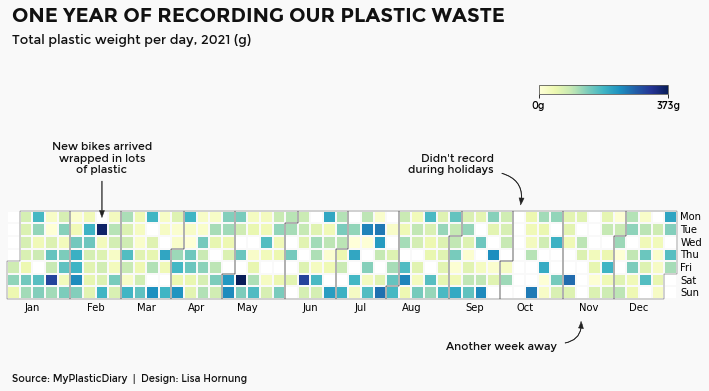

In [72]:
import calplot

#prepare data
all_days = pd.date_range('1/1/2021', periods=365, freq='D')
events = df_daily.groupby("date")["DV_plastic_weight"].sum()
events = pd.Series(events, index=all_days)

#set colour + get text properties
color = YlGnBu_9
b_color = "#f9f9f9"
font_r, font_b, title, subtitle = get_text()

#### plot
fig, ax = plt.subplots(figsize=(12,5))
fig.set_facecolor(b_color)
ax = calplot.yearplot(events, cmap=color.mpl_colormap, linewidth=0.4, linecolor=b_color, fillcolor='white',
                      edgecolor = '#333333',  dropzero=True)

# =========
# Arrows
#define style
style = "Simple, tail_width=0.5, head_width=5, head_length=7"
kw = dict(arrowstyle=style, color="#222222")

#define arrows
a1 = patches.FancyArrowPatch((7.5, 9.5), (7.5, 6.3),linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw, clip_on=False)
a2 = patches.FancyArrowPatch((39, 10), (40.6, 7.3),linewidth=0.5,
                            connectionstyle="arc3,rad=-.5", **kw, clip_on=False)
a3 = patches.FancyArrowPatch((44, -3.5), (45.4, -1.6),linewidth=0.5,
                            connectionstyle="arc3,rad=.5", **kw, clip_on=False)

#add arrows to plot
for a in [a1, a2,a3]:
    ax.add_patch(a)

## =========
#annotations
ax.text(7.5,10, "New bikes arrived\nwrapped in lots\nof plastic", fontsize=11, ha='center', fontproperties = font_r, color='#111111')  
ax.text(38.5, 10, "Didn't record\nduring holidays", fontsize=11, ha='right', fontproperties = font_r, color='#111111')
ax.text(43.5, -4, "Another week away", fontsize=11, ha='right', fontproperties = font_r, color='#111111')

## =========
#add colorbar (create mappable first and then plot)
cbaxes = fig.add_axes([0.74, 0.95, 0.15, 0.025]) #axes to hold coloebar
cmappable = ScalarMappable(norm=Normalize(0,int(events.max())), cmap=YlGnBu_9.mpl_colormap)
cb = plt.colorbar(cmappable, cax = cbaxes, anchor=(1,1.2), orientation='horizontal',
            ticks=[0,  int(events.max())])
cb.set_ticklabels(["0g", str(int(events.max()))+"g" ], fontproperties=font_r)
cb.outline.set_color('#555555')

# =========
#title and footer
x_title=0.13
plt.figtext(x_title,1.15, title, size=20, ha='left',  fontproperties = font_b, color='#111111')
plt.figtext(x_title,1.09, subtitle, size=13,ha='left',  fontproperties = font_r, color='#111111')

plt.figtext(x_title,0.15, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=10, ha='left', fontproperties = font_r, color='#111111')

#save
plt.savefig(os.path.join(root, "outputs//chart1-calendar-heatmap.png"), bbox_inches="tight",pad_inches=0.2)

plt.show()

# Chart 2: Treemap - largest category

# Chart 3: Reduction over time

#per month not per week due to missings

# Chart 2 - scatter

<ipython-input-420-608e4c5203e1>:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(ymin=0)
<ipython-input-420-608e4c5203e1>:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmin=0)


(2.03585689163032, 10303.278234455041)

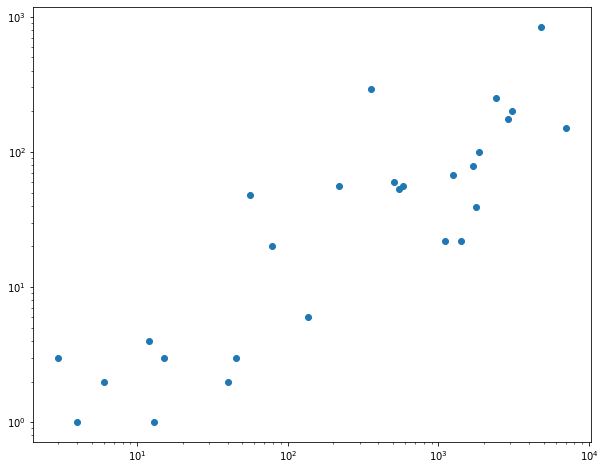

In [420]:
data = df.groupby(["sub_category_name"]).agg({"DV_plastic_weight":"sum", "quantity":"sum"}).reset_index()

#### plot
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(data["DV_plastic_weight"], data["quantity"])


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
#for i in range(len(data)):
   # plt.text(data["DV_plastic_weight"][i],data["quantity"][i], data["sub_category_name"][i])

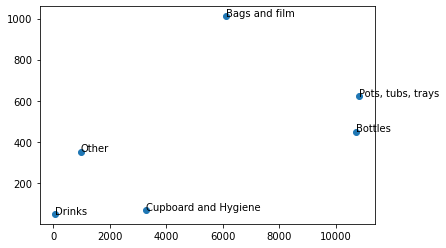

In [408]:
data = df.groupby(["category_name"]).agg({"DV_plastic_weight":"sum", "quantity":"sum"}).reset_index()

plt.scatter(data["DV_plastic_weight"], data["quantity"])

for i in range(len(data)):
    plt.text(data["DV_plastic_weight"][i],data["quantity"][i], data["category_name"][i])

# Chart 4: Sunburst

In [531]:
#Tokyo_20
from palettable.scientific.sequential import Tokyo_20
from palettable.wesanderson import Moonrise7_5
from palettable.cartocolors.diverging import Earth_7_r
from palettable.cartocolors.sequential import *
from palettable.cmocean.diverging import *
from palettable.colorbrewer.diverging import *

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def sunburst(nodes, ax, total=np.pi * 2, offset=0, level=0):
    #ax = ax or plt.subplot(111, projection='polar')

    if level == 0 and len(nodes) == 1:
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi * 2])
        ax.text(0, 0, label, ha='center', va='center')
        sunburst(subnodes, total=value, level=level + 1, ax=ax)
    elif nodes:
        d = np.pi * 2 / total
        labels = []
        widths = []
        local_offset = offset
        for label, value, subnodes in nodes:
            labels.append(label)
            widths.append(value * d)
            sunburst(subnodes, total=total, offset=local_offset,
                     level=level + 1, ax=ax)
            local_offset += value
        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5
        rects = ax.bar(values, heights, widths, bottoms, linewidth=1,
                       edgecolor='white', align='edge')
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            ax.text(x, y, label, rotation=rotation, ha='center', va='center') 

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()
        

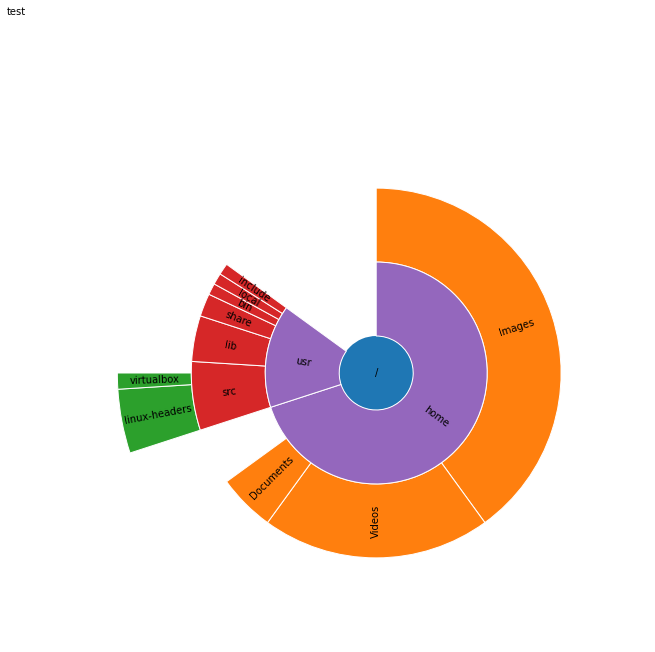

In [79]:
plt.figure(figsize=(10, 10))
axis = plt.subplot(111, polar=True)

data = [
    ('/', 100, [
        ('home', 70, [
            ('Images', 40, []),
            ('Videos', 20, []),
            ('Documents', 5, []),
        ]),
        ('usr', 15, [
            ('src', 6, [
                ('linux-headers', 4, []),
                ('virtualbox', 1, []),

            ]),
            ('lib', 4, []),
            ('share', 2, []),
            ('bin', 1, []),
            ('local', 1, []),
            ('include', 1, []),
        ]),
    ]),
]

sunburst(data, axis)

plt.figtext(0,1,"test")

plt.show()

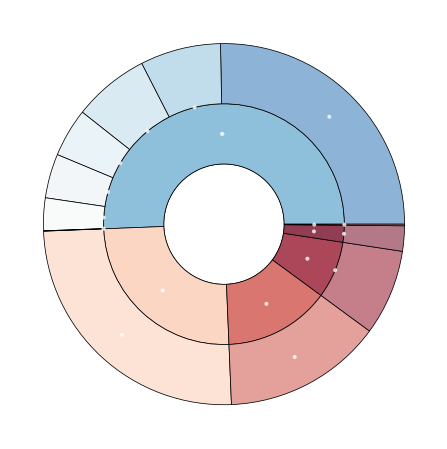

In [586]:
#data = stringvalues_to_pv({
#    'Pots, tubs, trays/?':                 10821,
#    'Pots, tubs, trays/Salad trays ':                 3087,
#    'Pots, tubs, trays/ Food pots & tubs':                 2918,
#    'Pots, tubs, trays/Plastic container':                 1861,
#    'Pots, tubs, trays/ Yoghurt pots':                 1691,
#    'Pots, tubs, trays/Street Food Bowl':                 1251,
#    'Pots, tubs, trays/ Styrofoam container':                13,
#    'Bottles/?':                 10707,
#    'Bags and film/?':                 6096,
#    'Cupboard and Hygiene/?':                 3280,
#    'Other/?':                 968,
#    'Drinks/?':                 62,
#})
#
#fig, ax = plt.subplots(figsize=(8,8))
#sbp = SunburstPlot(data, ax, plot_center=True, cmap = RdBu_11_r.mpl_colormap, plot_minimal_angle=0, origin=(50, 50))
#ax.set_title('Example SunburstPlot')
#
#sbp.plot(setup_axes=True)
#
#
#plt.show()